<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/master/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Matrix Factorization**
**Hilaire Bouaddi**

# **Abstract**

Objectives: 
The objectives of the lab were to:

    * understand how matrix vector product can be dramatically sped up using other data representation for certain matrices.
    * implement a direct linear solver
    
The 2nd objective encompasses the implementation of some procedure to have mtrices that can be easily inverted. In this lab, we are going to use the QR factorization. 

Methods:
In this lab, we allowed ourselves to use the numpy library to represent some of the data (matrices and vectors) and to use some built-in operations that were not the primary focus of the lab such as the dot product. 

Main Results: 
The choice of data representation of a matrix has a huge impact on the algorithm used and their running time. The sparse matrix vector product is linear.

Conclusion: 
The different objectives of the lab were reached. The first question gave great results regarding the speedup of the sparse product. The 2rd and 3rd question fulfilled the 2nd objective. 

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt 

# **Introduction**

For the sparse matrix vector product, we assume that A is sparse ($O(n)$ elements in the matrix). The pseudo code of the implementation of the matrix was studied in lecture. 

For the QR Factorization, we used the pseudo code seen in lecture. The aim of this factorization is to get two matrices that can be easily inverted, Q an orthogonal matrix and R an unpper triangular matrix. 

For the direct solver, we have: $Ax = b \iff QRx = b \iff Rx = Q^{-1}b \iff Rx = Q^Tb$.

We used the backward substitution seen in lecture to solve the upper triangular system. 

# **Method**

Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

## Sparse matrix vector product 

In [8]:
def sparse_representation(A):
    val = []
    col_idx = []
    row_pointer = []
    pointer = 0
    for i in range(len(A)):
        row_pointer.append(pointer)
        for j in range(len(A[0])):
            if A[i][j]:
                val.append(A[i][j])
                col_idx.append(j)
                pointer+=1
    row_pointer.append(len(val))
    return val, col_idx, row_pointer

def sparse_matrix_vector_product(val, col_idx, row_ptr, x):
    n = len(x)
    b = []
    for i in range(n):
        b.append(0)
        for j in range(row_ptr[i], row_ptr[i+1]):
            b[i] = b[i] + val[j] * x[col_idx[j]]
    
    return np.array(b)


## QR Factorization 

We will implement the Gram-Schimdt QR factorization seen in lecture. 

In [9]:
# Input: (real quadratic) matrix A
# Output: orthogonal matrix Q, upper triangular matrix R, such that A=QR


def QR_factorization(A):
    n = len(A)
    R = np.zeros((n, n))
    Q = np.zeros((n, n))
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], v) 
            v = v - R[i, j]*Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R


## Direct Solver

In [10]:
# Input: (real, quadratic) matrix A, vector b
# Output: vector x=A^-1b

def backward_substitution(R, b):
    n = len(b)
    x = np.zeros(n)
    x[n-1] = b[n-1]/R[n-1, n-1]
    for i in range(n-2, -1, -1):
        sum_ = 0 
        for j in range(i+1, n):
            sum_ = sum_ + R[i,j]*x[j]
        x[i] = (b[i] - sum_) / R[i, i]
    return x

def direct_solver(A, b):
    Q, R = QR_factorization(A)
    b2 = np.dot(Q.T, b)
    return backward_substitution(R, b2)    
        


# **Results**

## Tests: Sparse Matrix vector product 

In [11]:
## SEE BELOW THIS CELL TO SEE GRAPHS, will take a while if you run this (several minutes)

###
#We will use this code from lab1 for testing
"""
@param x: vector represented by 1D-array
@param A: matrix represented by 2D-array
returns Ax
"""
def matrix_vector_product(x, A):
    nbLinesA = len(A)
    nbColA = len(A[0])
    
    result = []
    for line in range(nbLinesA):
        element_line_i = 0
        for i in range(nbColA):
            element_line_i += A[line][i]*x[i]
        result.append(element_line_i)
    
    return result
###


number_of_tests_n = 20

time_mean = []
time_std = []
time_sparse_mean = []
time_sparse_std = []

N = list(range(1, 31)) 

for n in N: # this will take a while (minutes), see results below
    time_n = []
    time_sparse_n = []

    for _ in range(number_of_tests_n):
        M = np.random.randint(n**2, size=(n, n)) # this creates a mtrix of size (n*n) with random elements in 0, ... n²
        ## Removing n(n-1) elements so that there are n non null elements in the matrix
        for i in np.random.choice(range(n**2), n*(n-1), replace=False):
            j = i%n
            i = i//n
            M[i][j] = 0

        x = np.random.randint(n, size=(n,)) # creating a random vector

        val, col_idx, row_ptr = sparse_representation(M)

        n_operations = 500 # we make a lot of operations so we can measure something since the operations are very fast

        t1 = round(time.time() * 1000)
        for _ in range(n_operations):
            res1 = sparse_matrix_vector_product(val, col_idx, row_ptr, x)
        delta = (round(time.time()*1000) - t1) / n_operations
        time_sparse_n.append(delta) 


        t1 = round(time.time() * 1000)
        for _ in range(n_operations):
            res2 = np.array(matrix_vector_product(x, M))
            #res2 = np.dot(M, x)
        delta = (round(time.time()*1000) - t1) / n_operations
        time_n.append(delta) 


        if not np.array_equal(res1, res2): # we can verify while we are here that both methods return the same results 
            print("----PROBLEM----")
            print(res1)
            print(res2)

    time_n = np.array(time_n)
    time_sparse_n = np.array(time_sparse_n)
    time_mean.append(time_n.mean())
    time_std.append(time_n.std())
    time_sparse_mean.append(time_sparse_n.mean())
    time_sparse_std.append(time_sparse_n.std())
    


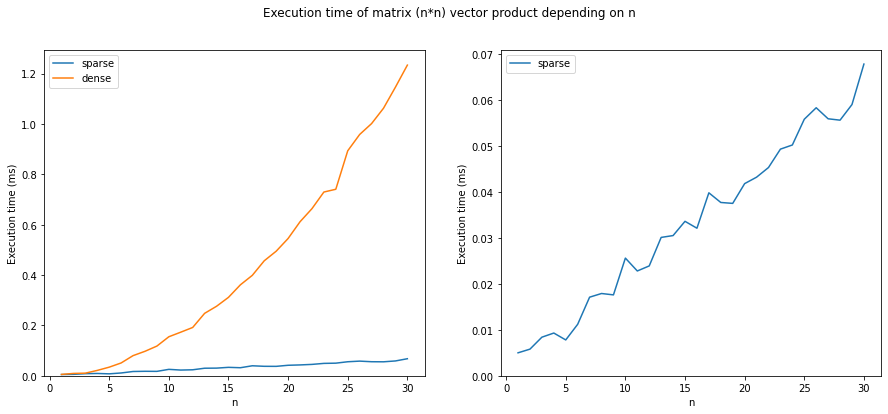

In [12]:
fig=plt.figure(figsize=(15,6))
fig.suptitle("Execution time of matrix (n*n) vector product depending on n")

plt.subplot(121)
plt.plot(N, time_sparse_mean, label="sparse")
plt.plot(N, time_mean, label="dense")
plt.xlabel("n")
plt.ylabel("Execution time (ms)")
plt.ylim(0)
plt.legend()

plt.subplot(122)
plt.plot(N, time_sparse_mean, label="sparse")
plt.xlabel("n")
plt.ylabel("Execution time (ms)")
plt.ylim(0)
plt.legend()


## Tests: QR Factorization

In [13]:
# Test: R upper triangular, Frobenius norms || Q^TQ-I ||_F, || QR-A ||_F

# IF NOTHING IS PRINTED, EVERYTHING WORKS

N_tests = 10000
n = 5
tolerance = 1e-10

for _ in range(N_tests): 
    A = np.random.rand(n, n)
    Q, R = QR_factorization(A)
    
    ## assert R is upper triangular
    for i in range(n):
        for j in range(i):
            if R[i, j]>0:
                print(f"Non null term at position ({i},{j})")
    
    ## Q is supposed to be orthogonal. That means that Q^-1 = Q^T
    # This means that Q^T * Q = I 
    # Let's verify that || Q^T * Q - I ||_F = 0 
    norm1 = np.linalg.norm(np.dot(Q.T, Q) - np.identity(n))
    if norm1 > tolerance:
        print(f"QR doesn't seem to be orthogonal with tolerance {tolerance}")
    
    ## assert that || QR-A ||_F is 0
    norm2 = np.linalg.norm(np.dot(Q, R) - A)
    if norm2 > tolerance:
        print(f"QR doesn't seem to be equal to A with tolerance {tolerance}")



## Tests: Direct Solver 

In [14]:
# First of all, we are going to generate random matrices A and vectors b and solve the linear system Ax = b. 
# We are then going to check if np.dot(A, x) is indeed equal to b. 

# Test: residual || Ax-b ||, and || x-y || where y is a manufactured solution with b=Ay

N_tests = 1000
n = 5
tolerance = 1e-10

for _ in range(N_tests): 
    A = np.random.rand(n, n)
    b = np.random.rand(n)
    
    x = direct_solver(A, b)
    
    # Let's verify that || Ax-b || = 0
    norm1 = np.linalg.norm(np.dot(A,x) - b)
    if norm1 > tolerance: 
        print(f"Error (norm1) superior than {tolerance}")
        
        
A = np.array([
    [1, 4, 6], 
    [2, 0, 5], 
    [0, 0, 1]
])
b = np.array([35, 35, 5])

# We solve this system easily on paper: 
# x_3 = 5 
# x_1 = 5 
# x_2 = 0
y = np.array([5, 0, 5])

x = direct_solver(A, b)

print("Expected x: ")
print(y)
print("Found x:")
print(x)
print(f"Error: {np.linalg.norm(y-x)}")

Expected x: 
[5 0 5]
Found x:
[ 5.00000000e+00 -6.95109563e-15  5.00000000e+00]
Error: 2.3011364206183087e-14


# **Discussion**, additional remarks

## Sparse Matrix Vector multiplication 

As we can see on the graphs, the sparse multiplication performs extremely well and way better than the naive implementation of lab1. It is interesting to note that the function np.dot of numpy gave even better results than our sparse matrix multiplication function meaning that np.dot has even more optimisations. We also observe that it looks like the sparse matrix multiplication is in $O(n)$. This is expected since the algorithm consists of 2 nested loops with one iterating n times and one that should iterate with an average of 1 (a sparse matrix has $O(n)$ non null elements).

## QR factorization 

The QR factorization seems to work. Over 10 000 tests have been made and R is strictly diagonal. However we had to have a tolerance on the orthogonality of Q and on the A = QR equality. This is due to finite precision computation mistakes. 

## Direct Solver 

The direct solver took advantage of what we did before with the QR factorization. Since there were some errors with the QR factorization, we also had to set a tolerance. 